# Testing to see how the model will work when we input the training, testing and validation files in a different way

Data cleaning for these datasets can be found in the fix-forecast-overlap notebook. 
Here we are still downscaling T2 with PSFC as a predictor variable for the NYC focused area.

# Import libraries

In [1]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models
import glob
import os

2025-01-23 11:06:25.476780: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-23 11:06:25.521201: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-23 11:06:25.522398: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-23 11:06:27.172405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!python --version

Python 3.8.18


# Define paths and retrieve files from server

Instead of having one file with all the data for the train test and val, we have seperate files that make up the train data, etc.
We do this because we need to input the files in a specific order due to it being forecast data and having hours overlap when they are joined
together in one file. Instead we need to feed the model one by one..


In [3]:
def load_datasets(input_dir):

    netcdf_files = sorted(glob.glob(os.path.join(input_dir, '*.nc')))
    
    if not netcdf_files:
        raise ValueError(f"No NetCDF files found in directory: {input_dir}")
    
    #Open datasets WITHOUT concatenating
    datasets = [xr.open_dataset(file) for file in netcdf_files]
    
    return datasets

#-----------------------------------------------------------------
uwrf_train_dir = '/D4/data/gvaillant/prep-uwrf/d02/day-final/train'
uwrf_val_dir = '/D4/data/gvaillant/prep-uwrf/d02/day-final/val'
uwrf_test_dir = '/D4/data/gvaillant/prep-uwrf/d02/day-final/test'

uwrf_train = load_datasets(uwrf_train_dir)
uwrf_val = load_datasets(uwrf_val_dir)
uwrf_test = load_datasets(uwrf_test_dir)

#-----------------------------------------------------------------
nam_train_dir = '/D4/data/gvaillant/NAM/2019/aligned/train'
nam_val_dir = '/D4/data/gvaillant/NAM/2019/aligned/val'
nam_test_dir = '/D4/data/gvaillant/NAM/2019/aligned/test'

nam_train = load_datasets(nam_train_dir)
nam_val = load_datasets(nam_val_dir)
nam_test = load_datasets(nam_test_dir)

# Define variables

In [4]:
#High resolution (uWRF) data
T2_hr_train = [ds.T2 for ds in uwrf_train]
T2_hr_val = [ds.T2 for ds in uwrf_val]
T2_hr_test = [ds.T2 for ds in uwrf_test]

PSFC_hr_train = [ds.PSFC for ds in uwrf_train]
PSFC_hr_val = [ds.PSFC for ds in uwrf_val]
PSFC_hr_test = [ds.PSFC for ds in uwrf_test]

#--------------------------
#Low resolution (NAM) data
T2_lr_train = [ds.T2 for ds in nam_train]
T2_lr_val = [ds.T2 for ds in nam_val]
T2_lr_test = [ds.T2 for ds in nam_test]

PSFC_lr_train = [ds.PSFC for ds in nam_train]
PSFC_lr_val = [ds.PSFC for ds in nam_val]
PSFC_lr_test = [ds.PSFC for ds in nam_test]

# Scale the data

In [5]:
T2_scaler_train = dds.StandardScaler(axis=None)
T2_scaler_train.fit(T2_hr_train)  

PSFC_scaler_train = dds.StandardScaler(axis=None)
PSFC_scaler_train.fit(PSFC_hr_train)
#----------------------------------------------
#High resolution (uWRF):
y_train = T2_scaler_train.transform(T2_hr_train)
y_val = T2_scaler_train.transform(T2_hr_val)
y_test = T2_scaler_train.transform(T2_hr_test)


y_z_train = PSFC_scaler_train.transform(PSFC_hr_train)
y_z_val = PSFC_scaler_train.transform(PSFC_hr_val)
y_z_test = PSFC_scaler_train.transform(PSFC_hr_test)

#-------------------------------------------------
#Low resolution (NAM)

x_train = T2_scaler_train.transform(T2_lr_train)
x_val = T2_scaler_train.transform(T2_lr_val)
x_test = T2_scaler_train.transform(T2_lr_test)

x_z_train = PSFC_scaler_train.transform(PSFC_lr_train)
x_z_val = PSFC_scaler_train.transform(PSFC_lr_val)
x_z_test = PSFC_scaler_train.transform(PSFC_lr_test)

# Compare original resolutions

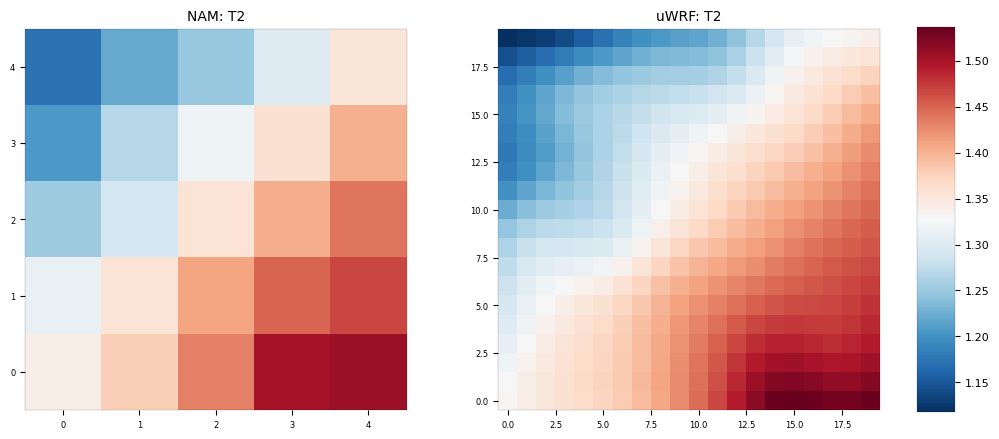

In [6]:
# Extract 2D slices and ensure numpy arrays
x_plot = x_train[0].values.squeeze() if hasattr(x_train[0], 'values') else np.array(x_train[0]).squeeze()
y_plot = y_train[0].values.squeeze() if hasattr(y_train[0], 'values') else np.array(y_train[0]).squeeze()

# Ensure 2D arrays
x_plot = x_plot if x_plot.ndim == 2 else x_plot[0]
y_plot = y_plot if y_plot.ndim == 2 else y_plot[0]

ecv.plot((x_plot, y_plot), share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM: T2', 'uWRF: T2'))

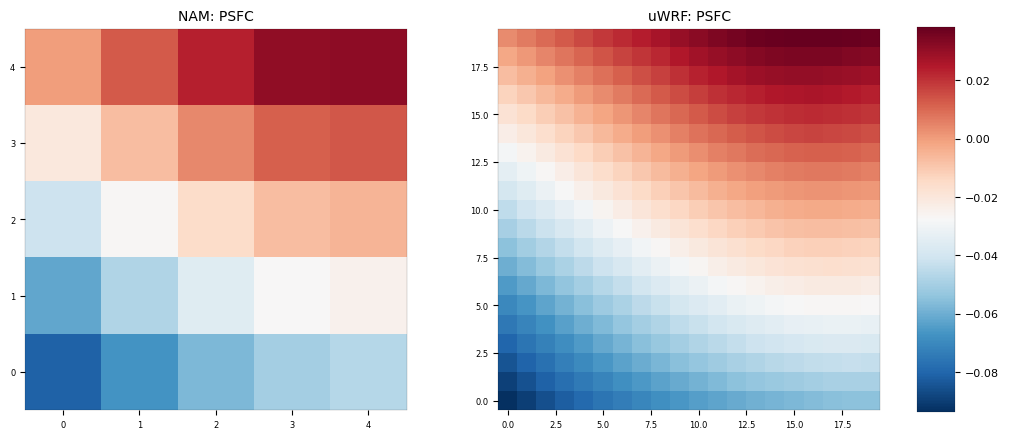

In [7]:
# Extract 2D slices and ensure numpy arrays
x_plot = x_z_train[0].values.squeeze() if hasattr(x_z_train[0], 'values') else np.array(x_z_train[0]).squeeze()
y_plot = y_z_train[0].values.squeeze() if hasattr(y_z_train[0], 'values') else np.array(y_z_train[0]).squeeze()

# Ensure 2D arrays
x_plot = x_plot if x_plot.ndim == 2 else x_plot[0]
y_plot = y_plot if y_plot.ndim == 2 else y_plot[0]

ecv.plot((x_plot, y_plot), share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM: PSFC', 'uWRF: PSFC'))

# Add channel dimension

In [8]:
y_train = [np.expand_dims(ds, axis=-1) for ds in y_train]
y_val = [np.expand_dims(ds, axis=-1) for ds in y_val]
y_test = [np.expand_dims(ds, axis=-1) for ds in y_test]

y_z_train = [np.expand_dims(ds, axis=-1) for ds in y_z_train]
y_z_val = [np.expand_dims(ds, axis=-1) for ds in y_z_val]
y_z_test = [np.expand_dims(ds, axis=-1) for ds in y_z_test]

#-----------------------------------------------------

x_train = [np.expand_dims(ds, axis=-1) for ds in x_train]
x_val = [np.expand_dims(ds, axis=-1) for ds in x_val]
x_test = [np.expand_dims(ds, axis=-1) for ds in x_test]

x_z_train = [np.expand_dims(ds, axis=-1) for ds in x_z_train]
x_z_val = [np.expand_dims(ds, axis=-1) for ds in x_z_val]
x_z_test = [np.expand_dims(ds, axis=-1) for ds in x_z_test]

# Verify shape

In [32]:
print("T2 hr data shape:")
print(y_train[0].shape, y_val[0].shape, y_test[0].shape)

print("PSFC hr data shape:")
print(y_z_train[0].shape, y_z_val[0].shape, y_z_test[0].shape)

print("T2 lr data shape:")
print(x_train[0].shape, x_val[0].shape, x_test[0].shape)

print("PSFC lr data shape:")
print(x_z_train[0].shape, x_z_val[0].shape, x_z_test[0].shape)

T2 hr data shape:
(29, 20, 20, 1) (29, 20, 20, 1) (29, 20, 20, 1)
PSFC hr data shape:
(29, 20, 20, 1) (29, 20, 20, 1) (29, 20, 20, 1)
T2 lr data shape:
(29, 5, 5, 1) (29, 5, 5, 1) (29, 5, 5, 1)
PSFC lr data shape:
(29, 5, 5, 1) (29, 5, 5, 1) (29, 5, 5, 1)


# Example coarsening method occuring during training:

For this model, we do not use the LR data (NAM) during training. Instead, we use a coarsened version (via interpolation) of the HR (uWRF) T2 and PSFC data. The DL4DS model carries out this interpolation on the fly by using the helper function dds.create_pair_hr_lr() (not to be called by the user). This process is done **automatically** inside the training loop (by calling one of the two (Supervised vs GAN) Trainer classes in DL4DS), which we examplify here with the spc upsampling. 

In [42]:
#new code for new format:
# Assuming y_train and y_z_train are lists of numpy arrays
#_ = dds.create_pair_hr_lr(y_train[0], None, 'spc', 4, None, None, y_z_train[0], None, True, interpolation='inter_area')

In [44]:
type(y_train)

list

# Training

Possible backbones:
* resnet
* densenet
* convnet
* convnext

In [45]:
ARCH_PARAMS = dict(n_filters=20,
                   n_blocks=4,
                   normalization=None,
                   dropout_rate=0.5,
                   dropout_variant='spatial',
                   attention=False,
                   activation='relu',
                   localcon_layer=False)

trainer = dds.SupervisedTrainer(
    backbone='densenet',
    upsampling='spc', 
    data_train=y_train, #**** fill in! ******
    data_val=y_val, #**** fill in! ******
    data_test=y_test, #**** fill in! ******
    data_train_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    data_val_lr=None, # here you cxan pass the LR dataset for training with explicit paired samples
    data_test_lr=None, # here you can pass the LR dataset for training with explicit paired samples
    scale=4, 
    time_window=None, 
    static_vars=None,
    predictors_train=[y_z_train], #**** fill in! ******
    predictors_val=[y_z_val], #**** fill in! ******
    predictors_test=[y_z_test], #**** fill in! ******
    interpolation='inter_area',
    patch_size=None, 
    batch_size=60,
    loss='mae',
    epochs=50, 
    steps_per_epoch=None, 
    validation_steps=None, 
    test_steps=None, 
    learning_rate=(1e-3, 1e-4), lr_decay_after=1e4,
    early_stopping=False, patience=6, min_delta=0, 
    save=False, 
    save_path=None,
    show_plot=True, verbose=True, 
    device='CPU',
    **ARCH_PARAMS)
trainer.run()

TypeError: `data_train` object must be of np.ndarray or xr.DataArray type